## Kütüphanalerin yüklenmesi

In [ ]:
import numpy as np # Dizi ve matris işlemleri için özelleşmiş bir kütüphanedir.
import matplotlib.pyplot as plt #Grafikleştirme işlemleri için kullanılan kütüphanedir.
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
#Eğitim öncesi görüntü ayarlarını yapmak için kullanılır.
#Görüntü artırma, ölçeklendirme gibi işlemler.
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import Flatten, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.regularizers import l1, l2, L1L2
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
import glob, os#dosya işlemleri için kullanılan kütüphanelerdir.
import random 

## Veri setinin yüklenmesi

In [3]:
#Dosya yolu
base_path = r"C:\Users\Turan\Desktop\DerinOgrenme\TezCalismalari\veriseti\Garbage classification\garbage classification\Garbage classification"
#dosyadan okunan fotoğrafların yüklendiği değişken
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print(len(img_list))

2527


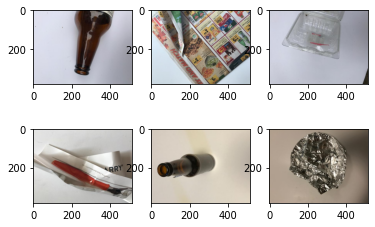

In [4]:
#Verisetinden örnek bir kaç görüntü
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

## Veri setinin modelin girişine hazırlanması ve bölünmesi

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,#Ölçeklendirme, verilen değerle çarpılır.
    shear_range=0.1,#Kesme açısı
    zoom_range=0.1,#Rastgele yaklaştırma
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,#Girilen değeri rastgele yatay çevirme.
    vertical_flip=True,#Girilen değeri rastgele dikey çevirme.
    validation_split=0.1#Doğrulama için ayrılan val'ın oranı
)

test_datagen = ImageDataGenerator(
    rescale=1./255,#ölçeklendirme
    validation_split=0.1#Doğrulama için ayrılan val'ın oranı
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(254, 254),#Fotoğrafın kaça kaç olacağı
    #batch_size=50,#Veri yığınlarının boyutu. 
    class_mode='categorical',#Sınıfların sırasını kontrol etmek için kullanılır
    subset='training',#Alt küme ayarlama validation/training
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(254, 254),#Fotoğrafın kaça kaç olacağı
    # batch_size=50,#Veri yığınlarının boyutu.
    class_mode='categorical',#Veri yığınlarının boyutu.
    subset='validation',#Alt küme ayarlama validation/training
    seed=0
)

#Etiketlerin gösterimi
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


## VGG modelinin yüklenmesi

In [7]:
vgg = VGG16(
    weights = 'imagenet',#İmageNet'in ağırlıklarını yükler.
    include_top = False,
    input_shape = (254, 254, 3))#Görüntünün giriş boyutu

In [8]:
#Son üç katmanı öğrenmeye kapatır.
for layer in vgg.layers[:-3]:
    layer.trainable = False

## Yeni modelin tanımlanması

In [9]:
model = Sequential()#Yeni model oluşturur.
 
model.add(vgg)#VGG modelini giriş olarak verir.(Functional)
 
model.add(Flatten())#Düzleştirme katmanı
model.add(Dense(1024, activation='relu'))#Tam bağlı katman
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))#Tam bağlı katman
model.add(Dropout(0.5))
#model.add(Dense(6, activation='softmax'))#Çıkış katmanı
model.add(Dense(6, use_bias=False, activation='linear', name='svm')) #activation='linear'

## SVM için kayıp fonksiyonunun hazırlanması

In [10]:
import tensorflow.keras.backend as K

def svm_loss(layer):
    weights = layer.weights[0]
    weights_tf = tf.convert_to_tensor(weights)
    
    def categorical_hinge_loss(y_true, y_pred):
        pos = K.sum(y_true * y_pred, axis=-1)
        neg = K.max((1.0 - y_true) * y_pred, axis=-1)
        hinge_loss = K.mean(K.maximum(0.0, neg - pos + 1), axis=-1)
        regularization_loss = 0.5*(tf.reduce_sum(tf.square(weights_tf)))
        return regularization_loss + 0.4*hinge_loss
    
    return categorical_hinge_loss

## modelin derlenmesi ve optimizasyon işlemlerinin yapılması

In [11]:
import tensorflow as tf
from keras.optimizers import RMSprop, SGD, Adam, Nadam

metrics = ['accuracy']
#optimizer = tf.keras.optimizers.RMSprop(lr=2e-3, decay=1e-5)
optimizer = optimizer=Nadam(lr=1e-4)

model.compile(optimizer=optimizer, loss=svm_loss(model.get_layer('svm')), metrics=metrics)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
svm (Dense)                  (None, 6)                 6

In [13]:
batch_size = 64 #32
epochs = 150 #İterasyon sayısı
#bir iterasyonda verilecek train ve test verilerinin oranlanması

In [14]:
#bir iterasyonda verilecek train ve test verilerinin oranlanması
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


filepath = "model_resnet50_svm_{epoch:02d}-{val_accuracy:.2f}.h5"#Kaydedilecek modelin adı
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)#Aşırı öğrenmeyi önlemek için kullanılır.
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#Modelin test verisi üzerinde başarısı her arttığında kaydetme işlemini yapar.
callbacks_list = [es, checkpoint1]#Eğitime verilmek için liste haline getirildi.

## Modelin eğitilmesi

In [16]:
history = model.fit_generator(
    generator=train_generator,
    epochs=epochs, 
    steps_per_epoch=steps_per_epoch, 
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

C:\Users\Turan\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
35/35 [==============================] - 38s 502ms/step - loss: 6.7240 - accuracy: 0.2536 - val_loss: 6.3902 - val_accuracy: 0.6146

Epoch 00001: val_accuracy improved from -inf to 0.61458, saving model to model_resnet50_svm_01-0.61.h5
Epoch 2/150
35/35 [==============================] - 20s 554ms/step - loss: 6.4695 - accuracy: 0.5276 - val_loss: 6.4059 - val_accuracy: 0.5938

Epoch 00002: val_accuracy did not improve from 0.61458
Epoch 3/150
35/35 [==============================] - 17s 476ms/step - loss: 6.4351 - accuracy: 0.5763 - val_loss: 6.3539 - val_accuracy: 0.6562

Epoch 00003: val_accuracy improved from 0.61458 to 0.65625, saving model to model_resnet50_svm_03-0.66.h5
Epoch 4/150
35/35 [==============================] - 17s 480ms/step - loss: 6.3915 - accuracy: 0.6376 - val_loss: 6.3600 - val_accuracy: 0.6562

Epoch 00004: val_accuracy did not improve from 0.65625
Epoch 5/150
35/35 [==============================] - 17s 476ms/step - loss: 6.3658 - accuracy: 0.6709

35/35 [==============================] - 17s 484ms/step - loss: 6.1209 - accuracy: 0.9532 - val_loss: 6.2521 - val_accuracy: 0.8229

Epoch 00040: val_accuracy did not improve from 0.90625
Epoch 41/150
35/35 [==============================] - 18s 491ms/step - loss: 6.1139 - accuracy: 0.9666 - val_loss: 6.2345 - val_accuracy: 0.8333

Epoch 00041: val_accuracy did not improve from 0.90625
Epoch 42/150
35/35 [==============================] - 19s 523ms/step - loss: 6.1164 - accuracy: 0.9642 - val_loss: 6.3115 - val_accuracy: 0.7917

Epoch 00042: val_accuracy did not improve from 0.90625
Epoch 43/150
35/35 [==============================] - 18s 514ms/step - loss: 6.1193 - accuracy: 0.9617 - val_loss: 6.2481 - val_accuracy: 0.8542

Epoch 00043: val_accuracy did not improve from 0.90625
Epoch 44/150
35/35 [==============================] - 18s 508ms/step - loss: 6.1091 - accuracy: 0.9710 - val_loss: 6.2326 - val_accuracy: 0.8333

Epoch 00044: val_accuracy did not improve from 0.90625
Epoch 45

## Sonuçlar

In [17]:
score = model.evaluate(validation_generator,batch_size=32)#Modeli test verisi ile dener.
score
print('Score Accuracy : {:.2f}%'.format(score[1]*100))#Sonucu yüzdeye uyarlar.

8/8 [==============================] - 13s 2s/step - loss: 6.2860 - accuracy: 0.8287
Score Accuracy : 82.87%


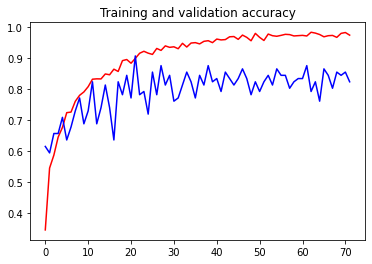

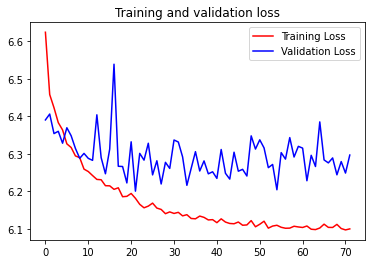

In [18]:
#Eğitim sürecinin görselleştirilmesi
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()